In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_method = 'Nelder-Mead'
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

We are in t = 69
[[[[           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]
   ...
   [           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]]

  [[           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]
   ...
   [           nan            nan       

In [4]:
par.simN = 1000

model.allocate_sim()

In [5]:
%time model.simulate()

CPU times: total: 2.83 s
Wall time: 7.67 s


<function matplotlib.pyplot.show(close=None, block=None)>

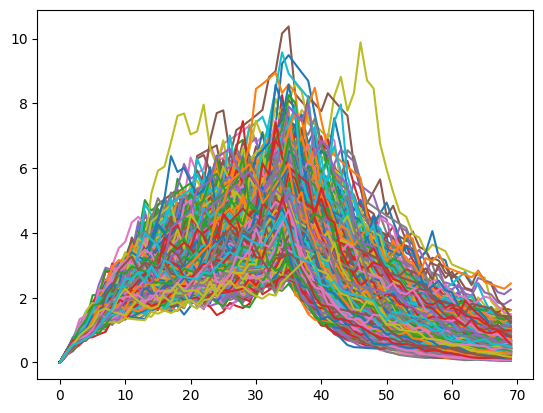

In [6]:
# plt.plot(np.arange(par.T),model.sim.a.T)
# plt.show
plt.plot(np.arange(par.T),model.sim.k.T)
plt.show
# plt.plot(np.arange(par.T),model.sim.a.T)
# plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

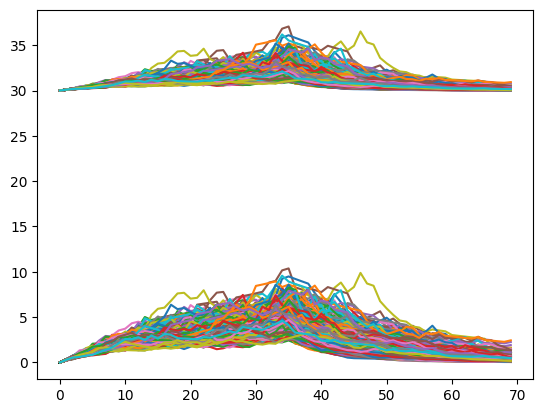

In [7]:
plt.plot(np.arange(par.T),model.sim.w.T)
plt.show
plt.plot(np.arange(par.T),model.sim.k.T)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

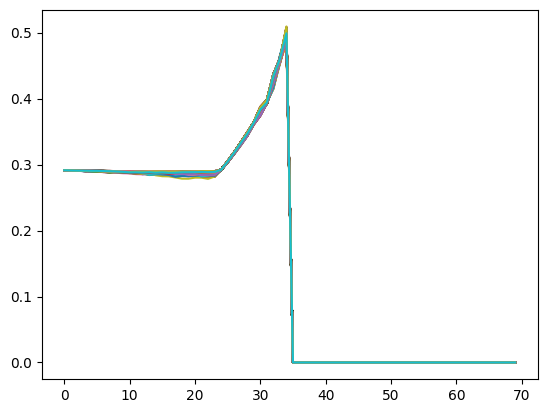

In [8]:
plt.plot(np.arange(par.T),model.sim.h.T)
plt.show

In [9]:
sol.c.shape

(70, 20, 20, 20)

In [10]:
sol.c

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

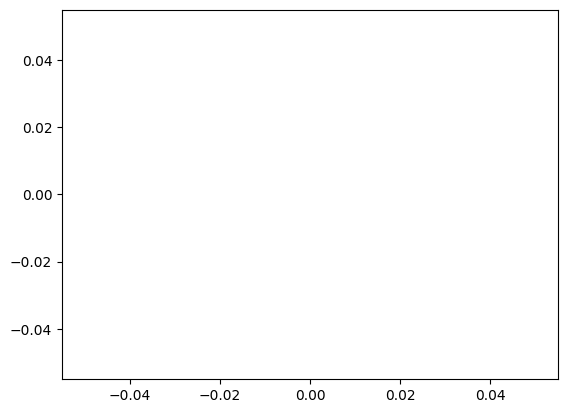

In [9]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 2, 1, i])


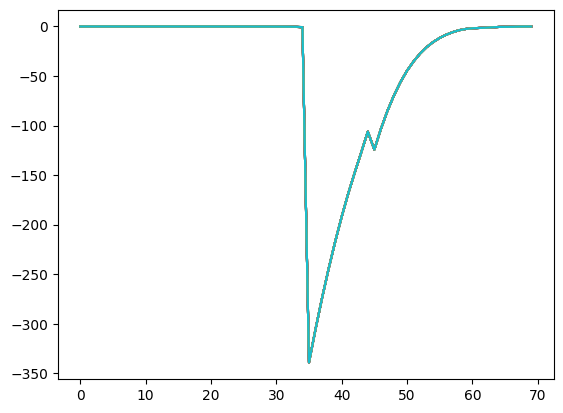

In [11]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 4, 4, i])

In [12]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([ 2.44016912e-04,  2.71514956e-04,  3.02111214e-04,  3.36156165e-04,
        3.74040316e-04,  4.16256671e-04,  4.63719875e-04,  5.73124408e-04,
        7.00795687e-04,  8.36733059e-04,  9.93522603e-04,  1.17068868e-03,
        1.35299837e-03,  1.59542955e-03,  1.88700399e-03,  2.20582233e-03,
        2.57412939e-03,  3.00683049e-03,  3.53534218e-03,  4.16661620e-03,
        4.90478381e-03,  5.77000794e-03,  6.63254699e-03,  7.55854577e-03,
        8.81157573e-03,  1.05459632e-02,  1.28557770e-02,  1.60750248e-02,
        2.03684397e-02,  2.65668721e-02,  3.88736573e-02,  6.96077066e-02,
        1.46462055e-01,  3.66116837e-01,  3.38203528e+02, -3.35511278e+01,
       -3.14522152e+01, -2.93399301e+01, -2.73158631e+01, -2.53052040e+01,
       -2.33088416e+01, -2.13005317e+01, -2.04232143e+01, -2.09238528e+01,
        1.81565142e+01, -2.07524389e+01, -1.82139808e+01, -1.56571734e+01,
       -1.35205881e+01, -1.14151862e+01, -9.38483398e+00, -7.92841209e+00,
       -6.49912089e+00, -

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B224264\AppData\Local\Temp\ipykernel_24668\4043882850.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B224264\AppData\Local\Temp\ipykernel_24668\4043882850.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


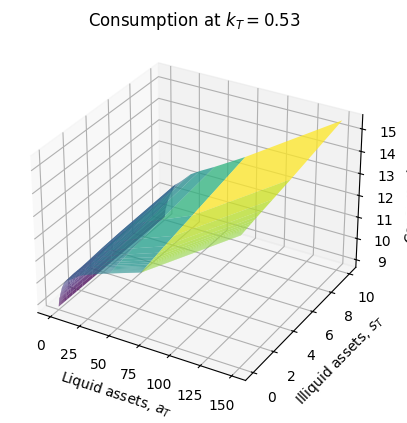

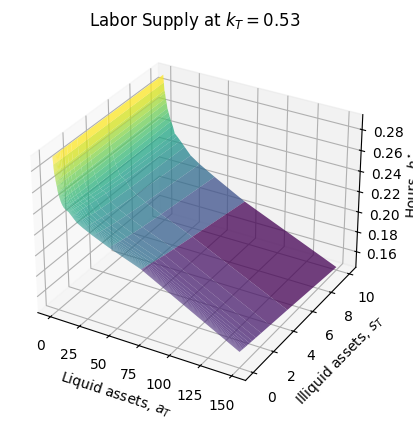

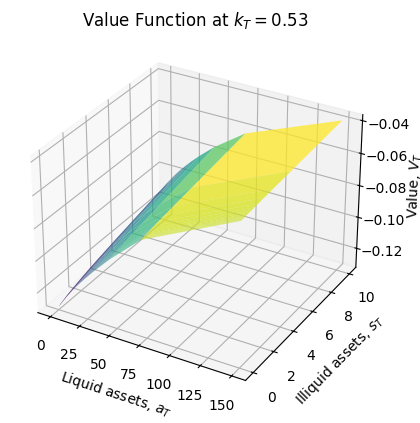

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 1
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 20
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
